In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker  
import concurrent.futures
import threading
import time

from timeit import default_timer as timer
from typing import Callable

plt.rcParams['figure.figsize']=(20, 10)
plt.rcParams['axes.titlesize']=20

# Statystyka - Zestaw 3
### Autor: Konrad Ulman

### Symulacja procesu kolejkowego

* Zadania przychodzą w tempie $ \lambda_A $
* Serwer obsługuje zadania w tempie $ \lambda_S $

* Oczekiwany czas pomiędzy przychodzeniem kolejnych zadań $ \mu_A = \dfrac{1}{\lambda_A} $ 
* Średni czas obsługi $ \mu_S = \dfrac{1}{\lambda_S} $ 

In [2]:
lock = threading.Lock()
queue_pos = 0

class Task:
    def __init__(self, id, start_queue, start, end_queue = None, end = None):
        self.id = id
        self.start_queue = start_queue
        self.end_queue = end_queue
        self.start = start
        self.end = end
        
    def recalculate_time(self, time):
        self.start = self.start - time
        self.end = self.end - time
        return self
    
    def __str__(self):
        return f'Task id is {self.id}'

    def __repr__(self):
        return str(self.__dict__)
    
def producer(task_size: int, delay: float) -> list:
    global queue_pos
    
    for id in np.arange(task_size):
        time.sleep(delay / 1000)
        with lock:
            q_pos = queue_pos
            queue_pos += 1
        
        yield Task(id, q_pos, timer())
    
def consume(delay: float, task: Task) -> Task:
    global queue_pos
    
    time.sleep(delay / 1000)
    with lock:
        queue_pos -= 1
        task.end_queue = queue_pos
    
    task.end = timer()
    return task
    
def consumer(delay: float, func: Callable, *args) -> list:
    start = timer()
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        producer_logs = []
        futures = []
        done_tasks = []
        for task in func(*args):
            futures.append(executor.submit(consume, delay, task))
            
        recalculate = lambda r: r.recalculate_time(start)
        return sorted([recalculate(future.result()) for future in concurrent.futures.as_completed(futures)], key=lambda x: x.id)

In [3]:
def extract_queues(tasks: list) -> list:
    start_queue = []
    end_queue = []
    for task in tasks:
        start_queue.append(task.start_queue)
        end_queue.append(task.end_queue)
    return start_queue, end_queue

def extract_points(tasks: list) -> list:
    start = []
    end = []
    for task in tasks:
        start.append(task.start)
        end.append(task.end)
    return start, end

In [73]:
def plot_points(tasks: list, annotate: bool = True) -> None:
    start_queue, end_queue = extract_queues(tasks)
    start_times, end_times = extract_points(tasks)
    
    plt.scatter(start_times, start_queue, color='r')
    plt.scatter(end_times, end_queue, color='b')
    
    if annotate:
        for i, e in enumerate(tasks):
            plt.text(start_times[i], start_queue[i] + max(max(start_queue)/20, 0.05), f'id: {e.id}', fontsize=12)
            plt.text(end_times[i], end_queue[i] - max(max(start_queue)/20, 0.05), f'id: {e.id}', fontsize=12)
    
    plt.xlabel('Czas', fontsize=20)
    plt.ylabel('Kolejka', fontsize=20)
    plt.ylim(0, max(max(start_queue) + 2, 1))
    plt.grid()
    plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f s'))
    plt.show()

In [76]:
def calc_wait_time(tasks: list) -> list:
    return [task.end - task.start for task in tasks]

def plot_wait(tasks: list) -> None:
    wait_time = calc_wait_time(tasks)
    plt.plot([task.id for task in tasks], wait_time, color='r')
    plt.xlabel('Numer zadania w systemie', fontsize=20)
    plt.ylabel('Czas oczekiwania', fontsize=20)
    plt.grid()
    
    ymax = max(max(wait_time) + 0.15, 1)
    yticks = np.arange(0, max(max(wait_time), ymax + 0.05), 0.05)
    plt.yticks(np.append(yticks, [max(wait_time), min(wait_time)]))
    plt.ylim(0, ymax)
    
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f s'))
    plt.show()

## Problem A

### Oczekiwany czas między zdarzeniami: $ \mu_A = 200[ms] , \lambda_A = \dfrac{1}{200} $

### Średni czas obsługi:  $ \mu_S = 150[ms] , \lambda_S = \dfrac{1}{150} $

### $ \lambda_A < \lambda_S $ - zadania wykonywane szybciej niż napływają 

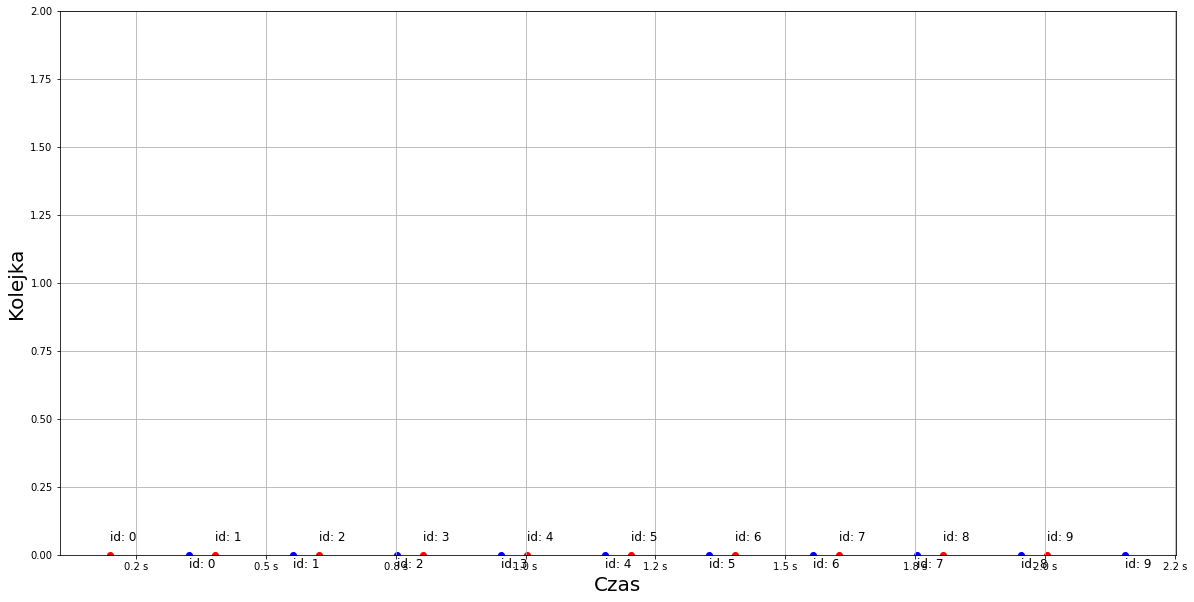

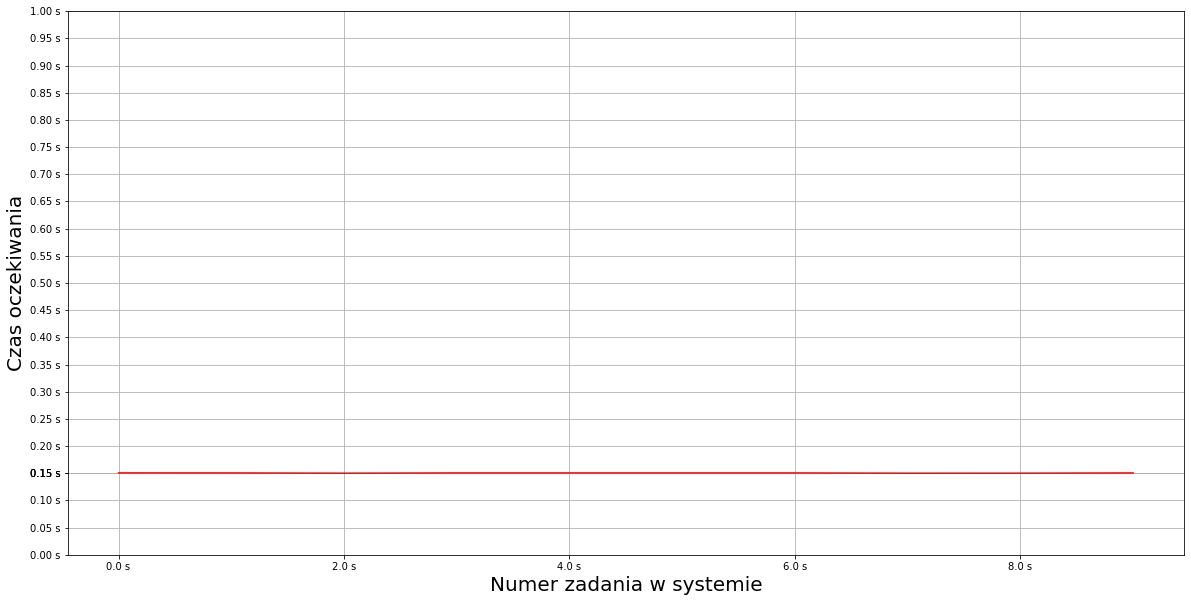

In [74]:
producer_delay = 200
consumer_delay = 150
num_of_tasks = 10

tasks = consumer(consumer_delay, producer, num_of_tasks, producer_delay)

plot_points(tasks)
plot_wait(tasks)

### Oczekiwany czas między zdarzeniami: $ \mu_A = 20[ms] , \lambda_A = \dfrac{1}{20} $

### Średni czas obsługi:  $ \mu_S = 100[ms] , \lambda_S = \dfrac{1}{100} $

### $ \lambda_A > \lambda_S $ - zadania wykonywane wolniej niż napływają 

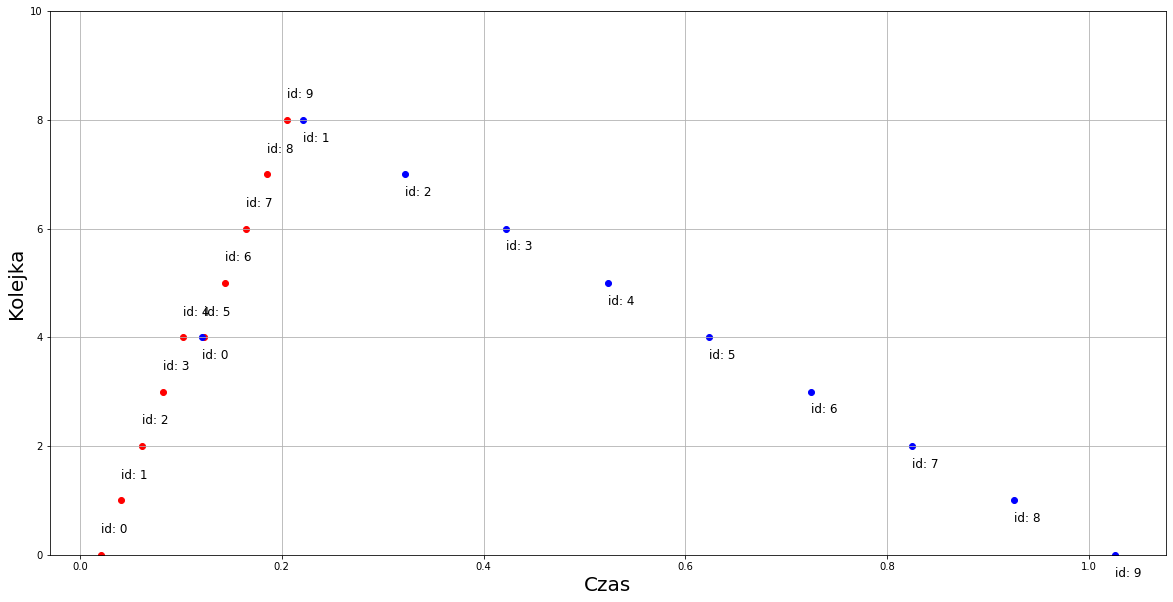

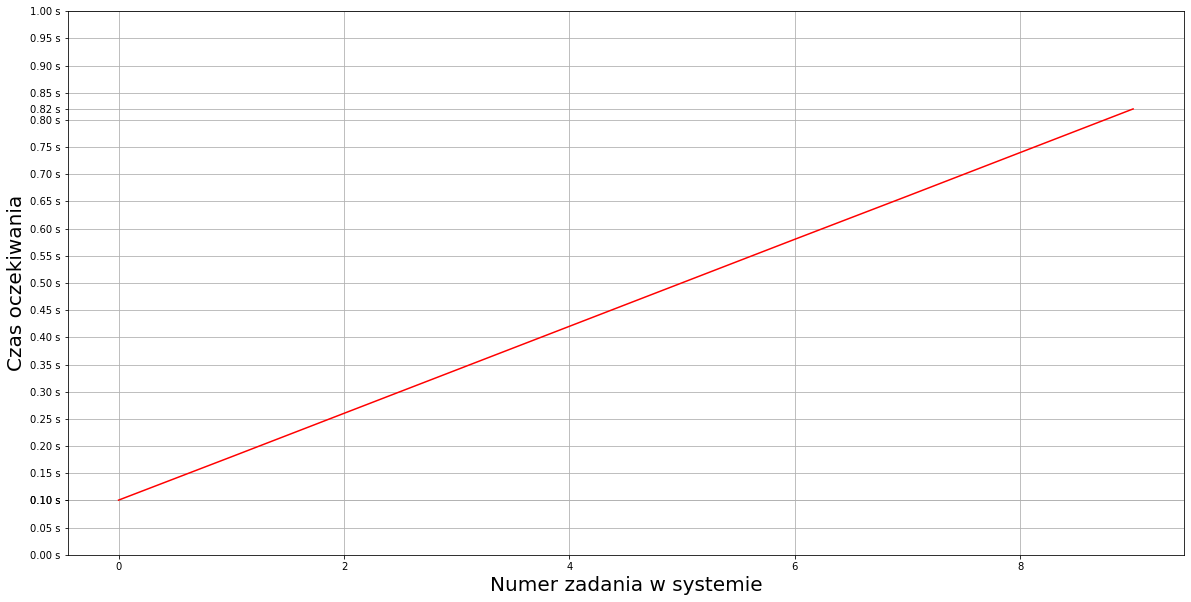

In [7]:
producer_delay = 20
consumer_delay = 100
num_of_tasks = 10

tasks = consumer(consumer_delay, producer, num_of_tasks, producer_delay)

plot_points(tasks)
plot_wait(tasks)

### Oczekiwany czas między zdarzeniami: $ \mu_A = 150[ms] , \lambda_A = \dfrac{1}{150} $

### Średni czas obsługi:  $ \mu_S = 150[ms] , \lambda_S = \dfrac{1}{150} $

### $ \lambda_A = \lambda_S $ - zadania wykonywane w takim samym tempie jak napływają 

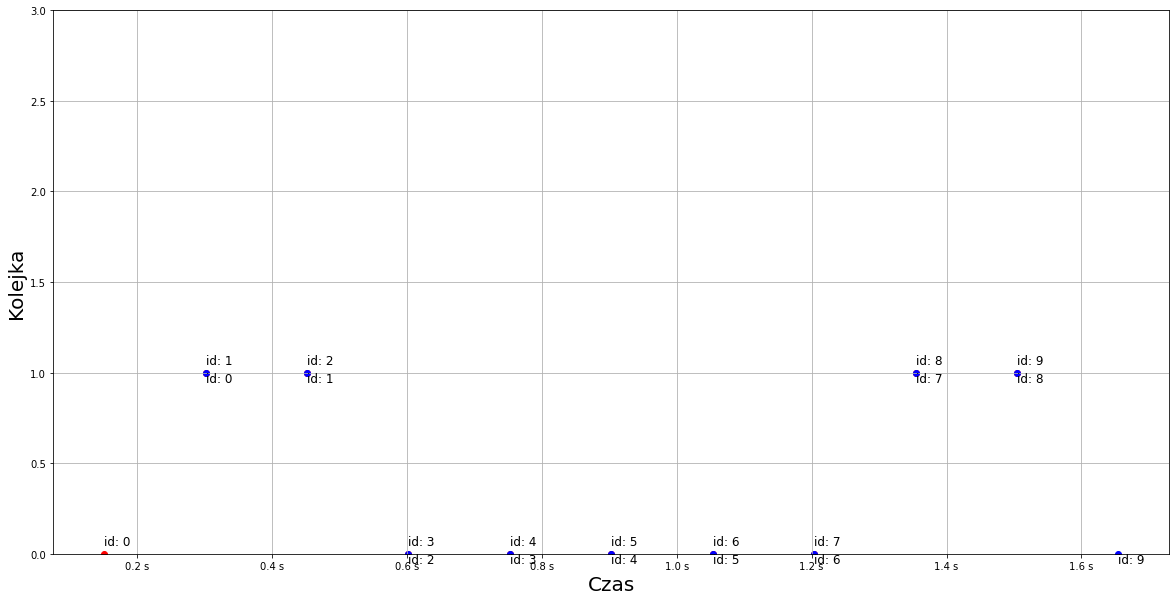

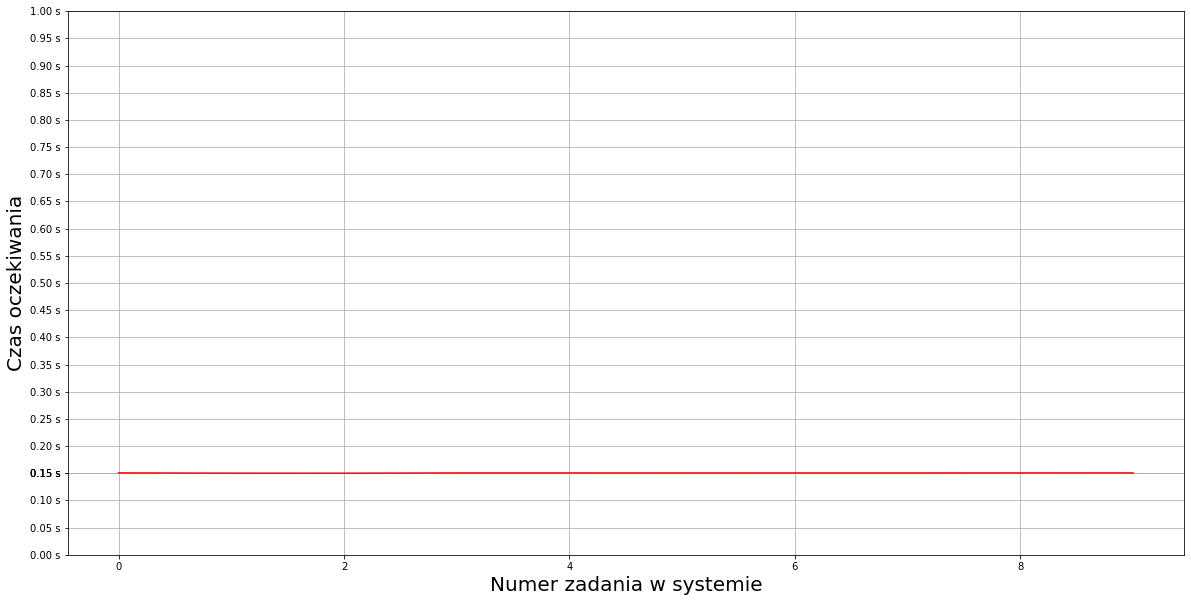

In [77]:
producer_delay = 150
consumer_delay = 150
num_of_tasks = 10

tasks = consumer(consumer_delay, producer, num_of_tasks, producer_delay)

plot_points(tasks)
plot_wait(tasks)

## Problem B

#### Prawo Little'a: "Średnia liczba rzeczy/klientów w systemie jest równa iloczynowi średniego czasu przebywania w systemie oraz średniego tempa ich przybywania."

### $ E(X) = \lambda_A * E(R),\, E(R) = E(X) * \mu_A $
$ E(X) $ - liczba zadań w systemie,

$ E(R) $ - czas spędzony w systemie

### Średni czas obsługi: $ \mu_S =  200[ms] , \lambda_S = \dfrac{1}{200} $

In [9]:
def littles_law(tasks_in_system: int, consumer_delay: int) -> int:
    return tasks_in_system * consumer_delay

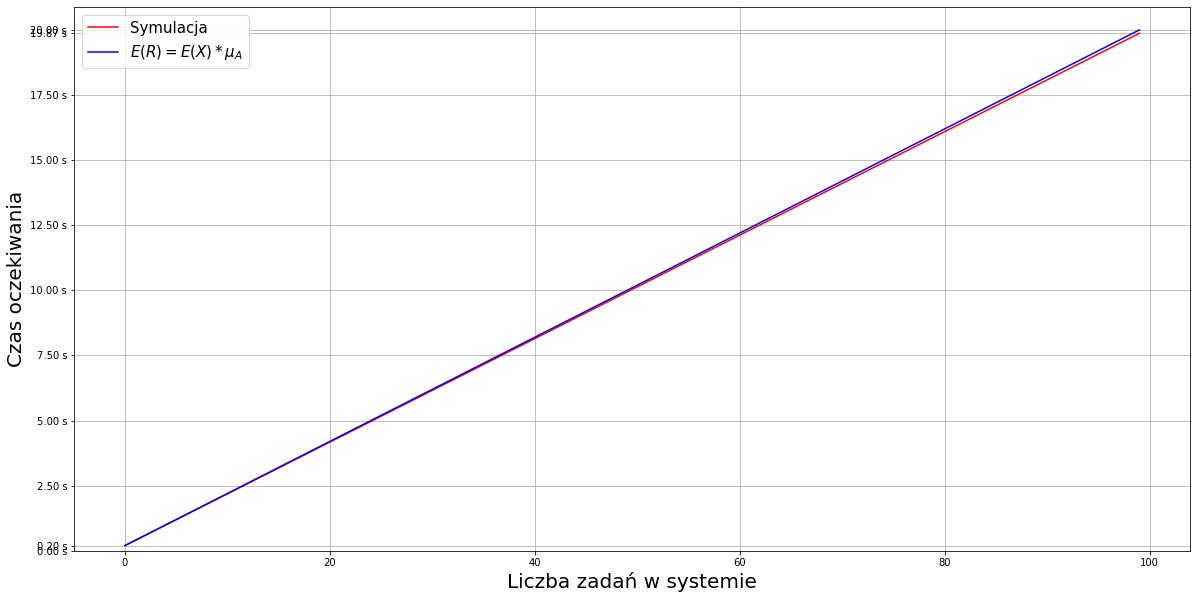

Czas oczekiwania symulacji po 100 krokach: 19.869098499999836[s]
E(R) = 20.0[s]


In [10]:
producer_delay = 1 # stan początkowy symulacji - wszystkie zadania w systemie
consumer_delay = 200
num_of_tasks = 100

tasks = consumer(consumer_delay, producer, num_of_tasks, producer_delay)

wait_time = calc_wait_time(tasks)
llaw = [littles_law(task.id + 1, consumer_delay) / 1000 for task in tasks]

plt.plot([task.id for task in tasks], wait_time, color='r', label='Symulacja')
plt.plot([task.id for task in tasks], llaw, color='b', label='$E(R) = E(X) * \mu_A$')

plt.xlabel('Liczba zadań w systemie', fontsize=20)
plt.ylabel('Czas oczekiwania', fontsize=20)
plt.grid()
plt.legend(loc='upper left', prop={'size': 15})
plt.ylim(0, max(wait_time) + 1)
plt.yticks(np.append(np.arange(0, max(wait_time), 2.5), [min(wait_time), max(wait_time), max(llaw)]))
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f s'))
plt.show()

print(f'Czas oczekiwania symulacji po {num_of_tasks} krokach: {max(wait_time)}[s]')
print(f'E(R) = {max(llaw)}[s]')

## Problem C

### Zatykanie się systemu

### Oczekiwany czas między zdarzeniami: $ \mu_A = 20[ms] , \lambda_A = \dfrac{1}{20} $

### Średni czas obsługi:  $ \mu_S = 100[ms] , \lambda_S = \dfrac{1}{100} $

### $ \lambda_A = \lambda_S $ - zadania wykonywane w takim samym tempie jak napływają 

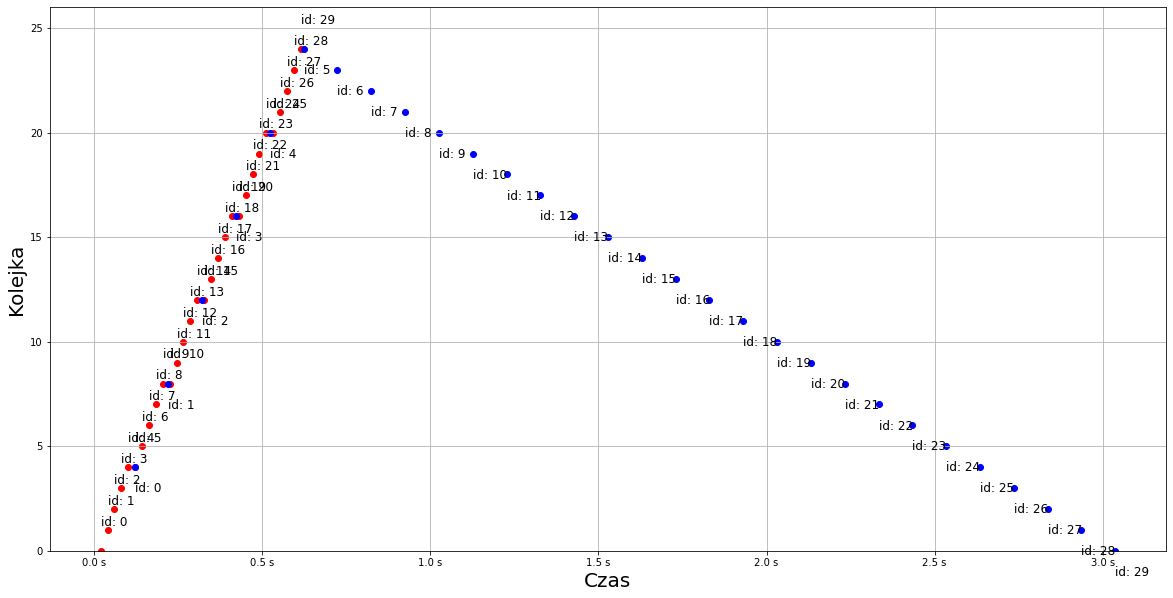

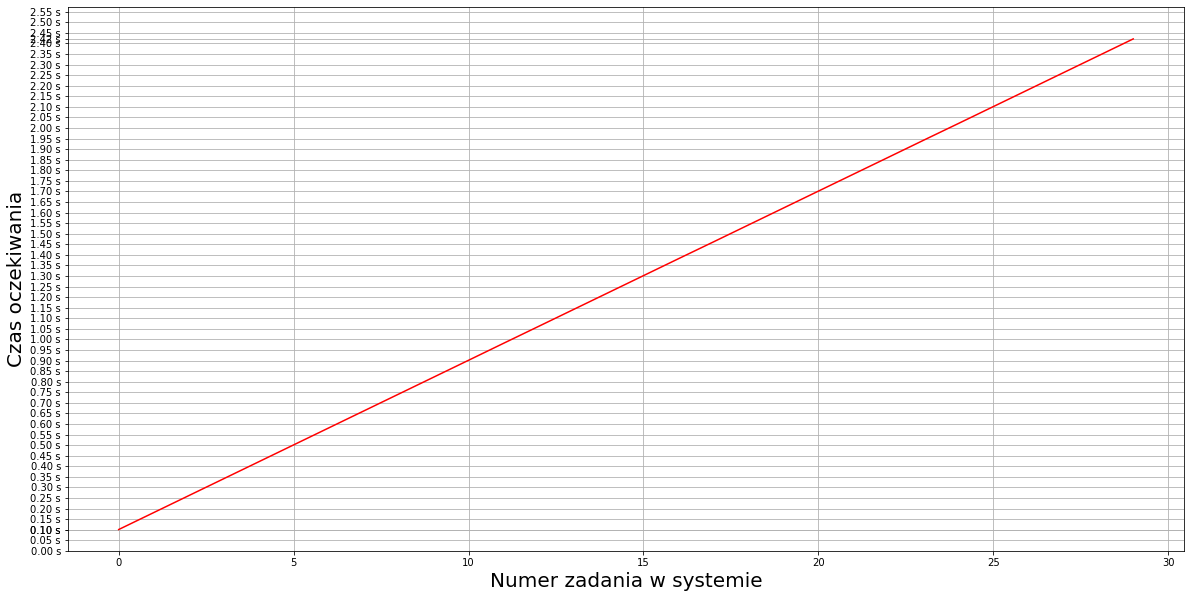

In [84]:
producer_delay = 20
consumer_delay = 100
num_of_tasks = 30

tasks = consumer(consumer_delay, producer, num_of_tasks, producer_delay)

plot_points(tasks)
plot_wait(tasks)

In [85]:
la = 1/20
ls = 1/100

### Zależności czasowe
### $(\lambda_A - \lambda_S)t$ - tempo narastania zadań w kolejce

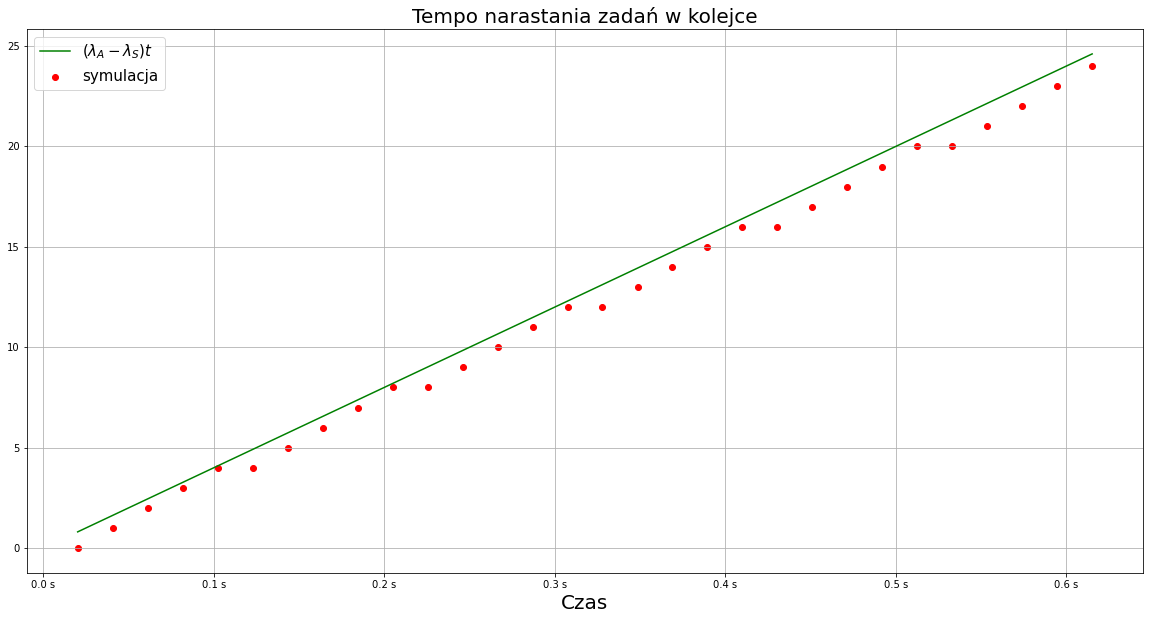

In [92]:
plt.scatter(start_times, [task.start_queue for task in tasks], color='r', label='symulacja')
plt.title('Tempo narastania zadań w kolejce')
plt.xlabel('Czas', fontsize=20)
plt.ylabel('', fontsize=20)
plt.grid()
plt.plot([task.start for task in tasks], [(la-ls) * task.start * 1000 for task in tasks], color='g', label='$(\lambda_A - \lambda_S)t$')
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f s'))
plt.legend(loc='upper left', prop={'size': 15})
plt.show()

### $(\dfrac{\lambda_A - \lambda_S}{\lambda_S})t$ - tempo wzrostu czasu oczekiwania na wykonanie zadania

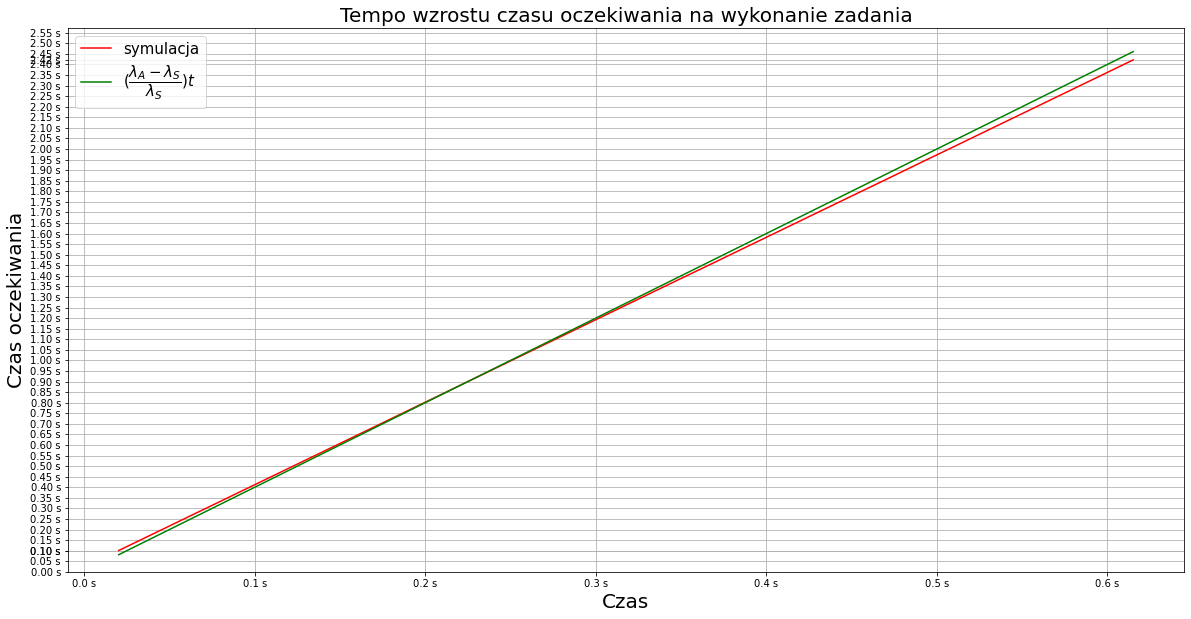

In [94]:
wait_time = calc_wait_time(tasks)
plt.plot([task.start for task in tasks], wait_time, color='r', label='symulacja')
plt.xlabel('Czas', fontsize=20)
plt.ylabel('Czas oczekiwania', fontsize=20)
plt.grid()

ymax = max(max(wait_time) + 0.15, 1)
yticks = np.arange(0, max(max(wait_time), ymax + 0.05), 0.05)
plt.yticks(np.append(yticks, [max(wait_time), min(wait_time)]))
plt.ylim(0, ymax)

plt.plot([task.start for task in tasks], [((la-ls)/ls) * task.start for task in tasks], color='g', label='$(\dfrac{\lambda_A - \lambda_S}{\lambda_S})t$')
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f s'))
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f s'))
plt.legend(loc='upper left', prop={'size': 15})
plt.title('Tempo wzrostu czasu oczekiwania na wykonanie zadania')
plt.show()

## Problem D

### Oczekiwany czas między zdarzeniami: $ \mu_A = 20[ms] , \lambda_A = \dfrac{1}{20} $

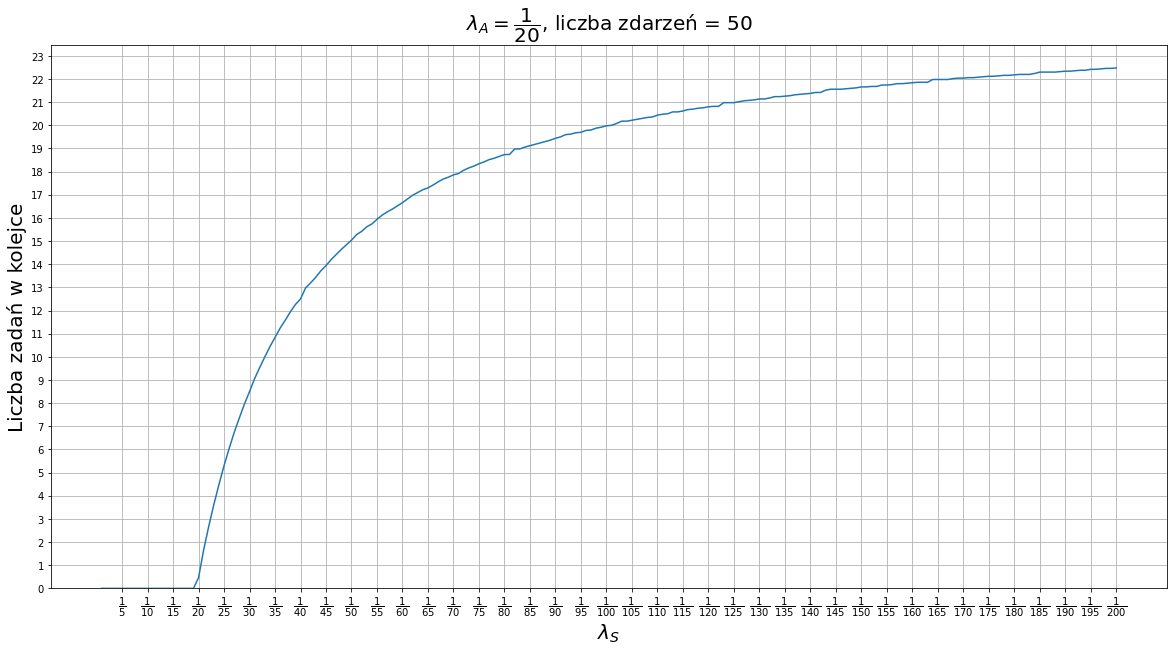

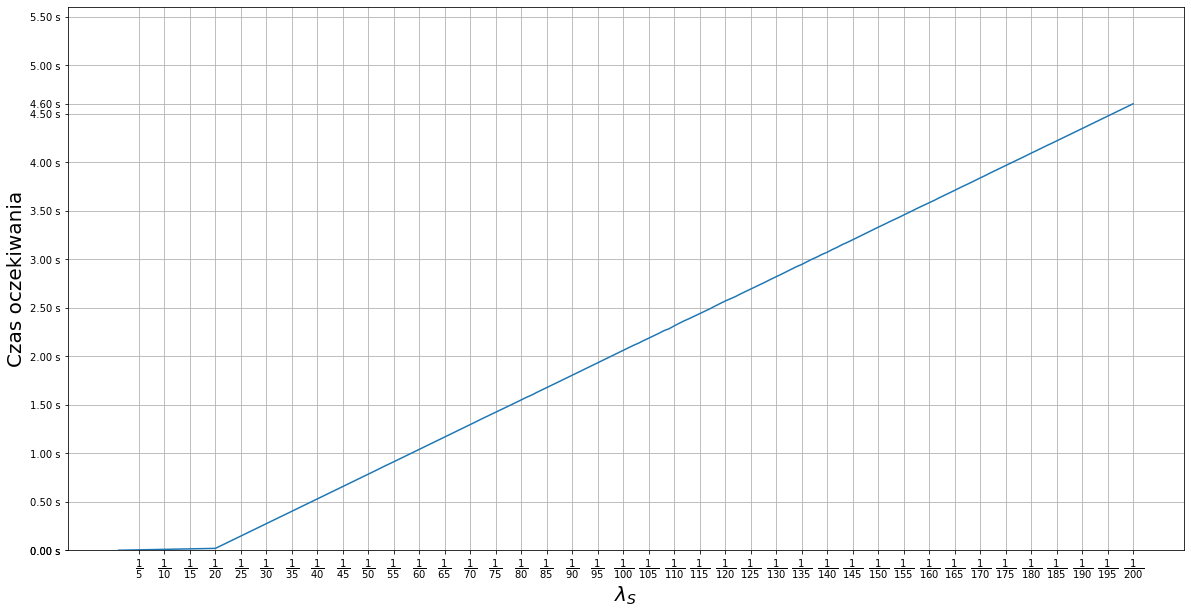

In [13]:
producer_delay = 20
num_of_tasks = 50

queues = []
wait_times = []
ar = np.arange(1, 201, 1)
for ls in ar:
    tasks = consumer(ls, producer, num_of_tasks, producer_delay)
    w = calc_wait_time(tasks)
    q = [task.start_queue for task in tasks]
    queues.append(sum(q) / len(q))
    wait_times.append(sum(w) / len(w))
    
plt.plot(ar, queues)
plt.grid()
plt.xticks(np.arange(5, 205, 5))
plt.yticks(np.arange(0, max(queues) + 1, 1))
plt.gca().xaxis.set_major_formatter(lambda x, pos: '$\dfrac{1}{' + str(int(x)) + '}$')
plt.xlabel('$\lambda_S$', fontsize=20)
plt.ylabel('Liczba zadań w kolejce', fontsize=20)
plt.ylim(0, max(queues) + 1)
plt.title('$\lambda_A = \dfrac{1}{' + str(int(producer_delay)) + '}$, liczba zdarzeń = ' + str(num_of_tasks))
plt.show()

plt.plot(ar, wait_times)
plt.grid()
plt.xticks(np.arange(5, 205, 5))
plt.yticks(np.append(np.arange(0, max(wait_times) + 1, 0.5), [min(wait_times), max(wait_times)]))
plt.gca().xaxis.set_major_formatter(lambda x, pos: '$\dfrac{1}{' + str(int(x)) + '}$')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f s'))
plt.xlabel('$\lambda_S$', fontsize=20)
plt.ylabel('Czas oczekiwania', fontsize=20)
plt.ylim(0, max(wait_times) + 1)
plt.show()

### Średni czas obsługi:  $ \mu_S = 20[ms] , \lambda_S = \dfrac{1}{20} $

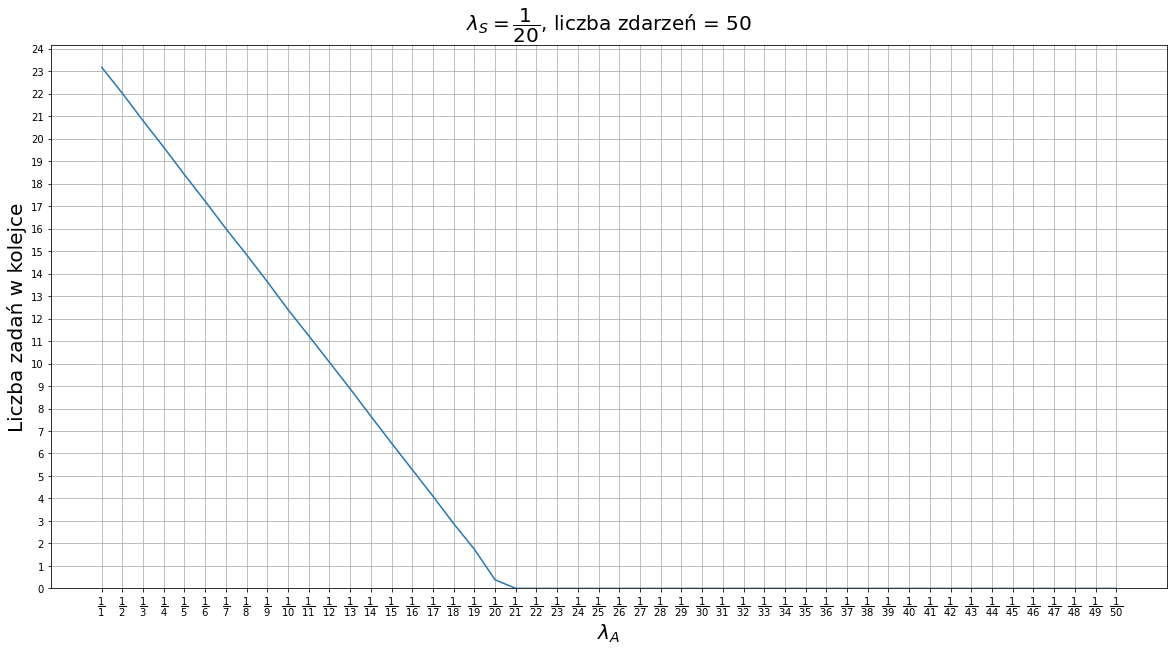

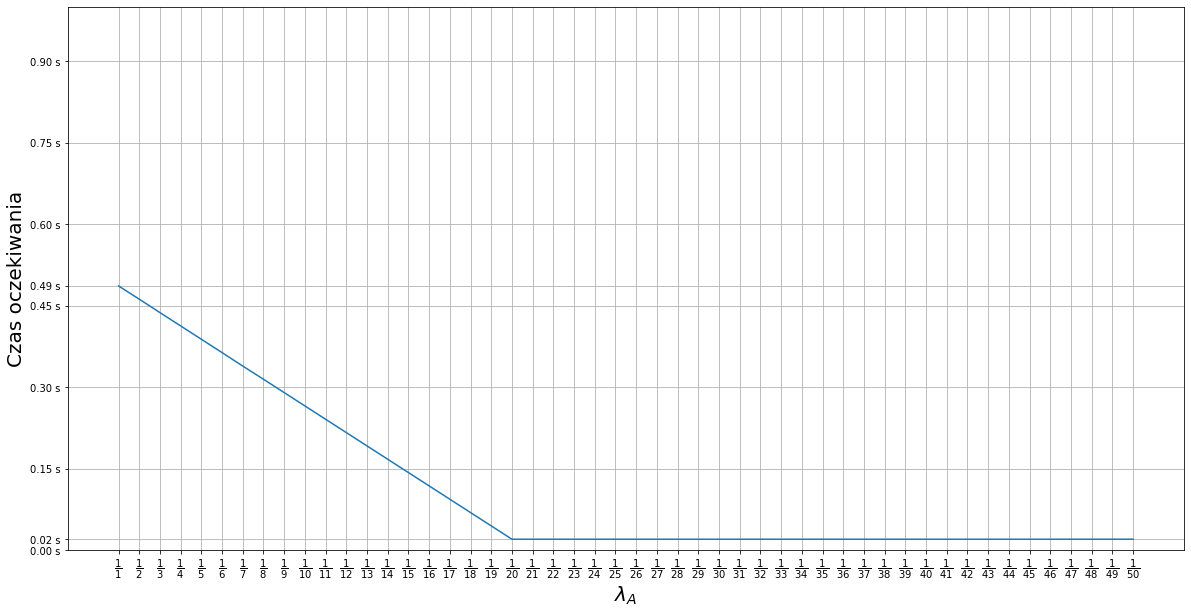

In [14]:
consumer_delay = 20
num_of_tasks = 50

queues = []
wait_times = []
ar = np.arange(1, 51, 1)
for la in ar:
    tasks = consumer(consumer_delay, producer, num_of_tasks, la)
    w = calc_wait_time(tasks)
    q = [task.start_queue for task in tasks]
    queues.append(sum(q) / len(q))
    wait_times.append(sum(w) / len(w))
    
plt.plot(ar, queues)
plt.grid()
plt.xticks(ar)
plt.yticks(np.arange(0, max(queues) + 1, 1))
plt.gca().xaxis.set_major_formatter(lambda x, pos: '$\dfrac{1}{' + str(int(x)) + '}$')
plt.xlabel('$\lambda_A$', fontsize=20)
plt.ylabel('Liczba zadań w kolejce', fontsize=20)
plt.ylim(0, max(queues) + 1)
plt.title('$\lambda_S = \dfrac{1}{' + str(int(consumer_delay)) + '}$, liczba zdarzeń = ' + str(num_of_tasks))
plt.show()

plt.plot(ar, wait_times)
plt.grid()
plt.xticks(ar)
plt.yticks(np.append(np.arange(0, max(wait_times) + 1, 0.15), [min(wait_times), max(wait_times)]))
plt.gca().xaxis.set_major_formatter(lambda x, pos: '$\dfrac{1}{' + str(int(x)) + '}$')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f s'))
plt.xlabel('$\lambda_A$', fontsize=20)
plt.ylabel('Czas oczekiwania', fontsize=20)
plt.ylim(0, 1)
plt.show()

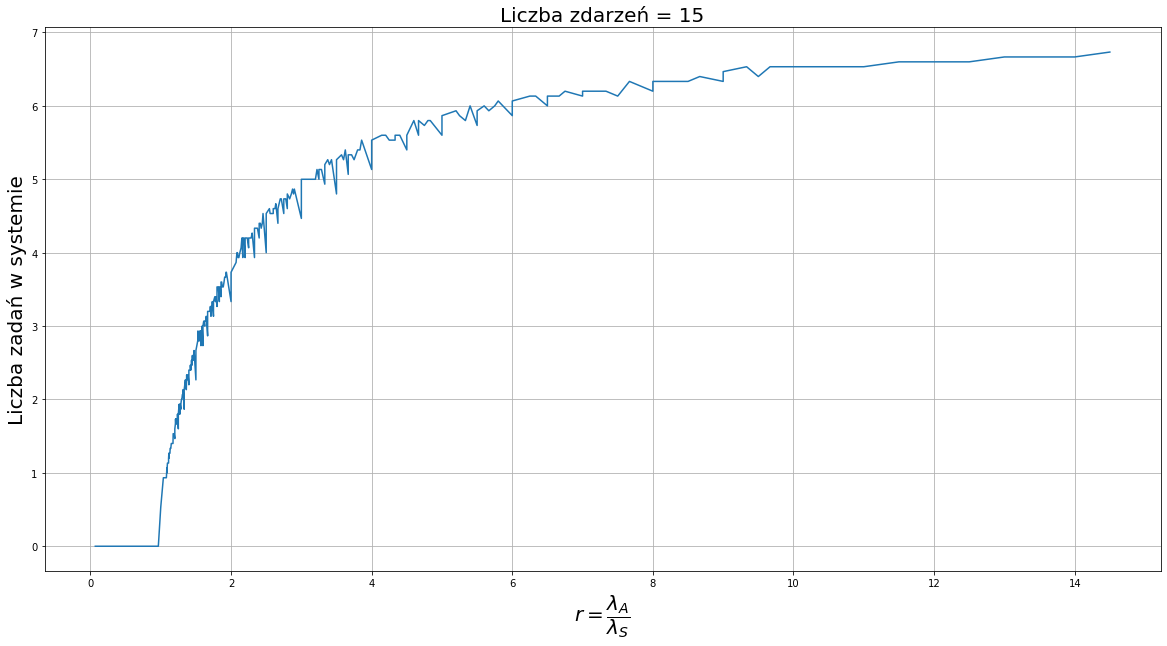

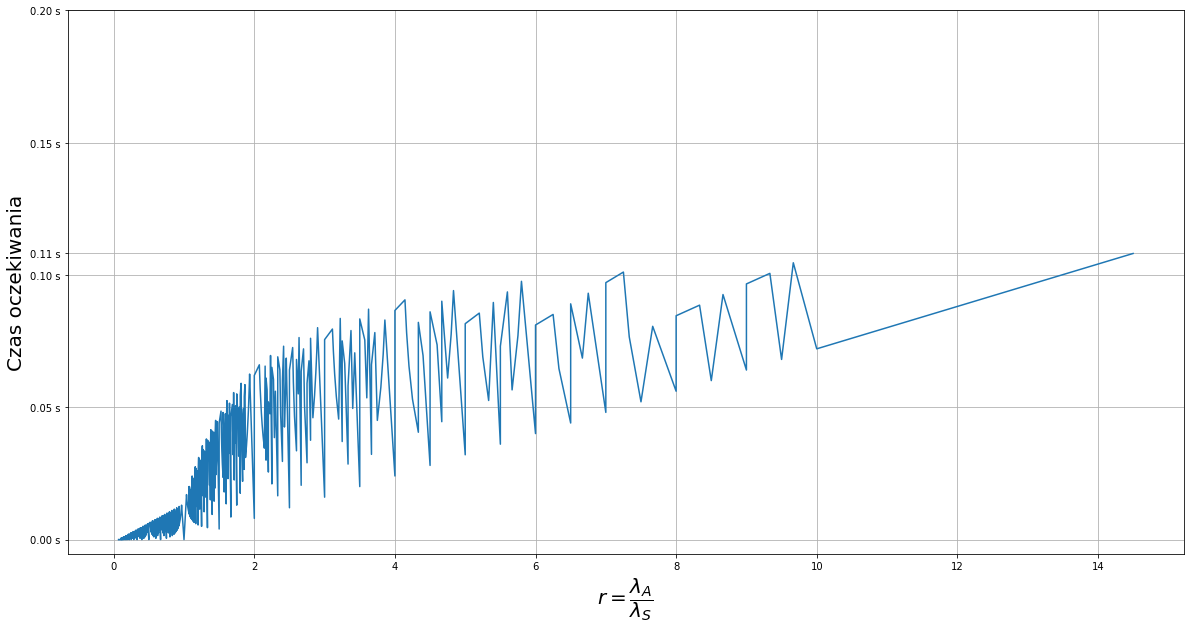

In [15]:
num_of_tasks = 15

class R:
    def __init__(self, r, queue, wait):
        self.r = r
        self.queue = queue
        self.wait = wait
        
def calculate_r(us, ua):
    tasks = consumer(us, producer, num_of_tasks, ua)
    q = [task.start_queue for task in tasks]
    w = calc_wait_time(tasks)
    avg_q = sum(q) / len(q)
    r = us / ua
    return R(r, avg_q, sum(w) / len(w))
        
r = [calculate_r(1, 1)]
ar = np.arange(1, 15, 0.5)
for us in ar:
    for ua in ar:
        if us != ua:
            r.append(calculate_r(us, ua))

r = sorted(r, key=lambda x: x.r)
queues = [x.queue for x in r]
wait_times = [x.wait for x in r]
r = [x.r for x in r]

plt.plot(r, queues)
plt.grid()
plt.xlabel('$r = \dfrac{\lambda_A}{\lambda_S}$', fontsize=20)
plt.ylabel('Liczba zadań w systemie', fontsize=20)
plt.title(f'Liczba zdarzeń = {num_of_tasks}')
plt.show()

plt.plot(r, wait_times)
plt.grid()
plt.yticks(np.append(np.arange(min(wait_times), max(wait_times) + 0.1, 0.05), max(wait_times)))
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f s'))
plt.xlabel('$r = \dfrac{\lambda_A}{\lambda_S}$', fontsize=20)
plt.ylabel('Czas oczekiwania', fontsize=20)
plt.show()